<a href="https://colab.research.google.com/github/bachvu98/Data-Mining/blob/main/Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Epitopes Classification

## Problem Statement

The goal of this report is to present a fully developed data mining solution whilst showing the whole process of its development. All observations in our data are related to linear B-Cell epitopes, which are protein regions of interest for a variety of applications in immunology. The goal is to develop a
classification model to predict the class of new, previously unseen observations with the
best possible classification performance.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, matthews_corrcoef, make_scorer

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Get Data

Read in the file. This dataset contains 4907 rows and 451 columns. Out of which one is dependent variable and rest 450 are independent variables — physico-chemical characteristics.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/bachvu98/Data-Mining/main/CW_data.csv')
df

,Info_PepID,Info_protein_id,Info_center_pos,Info_AA,Info_window_seq,feat_seq_entropy,feat_C_atoms,feat_H_atoms,feat_N_atoms,feat_O_atoms,feat_S_atoms,feat_molecular_weight,feat_Perc_Tiny,feat_Perc_Small,feat_Perc_Aliphatic,feat_Perc_Aromatic,feat_Perc_NonPolar,feat_Perc_Polar,feat_Perc_Charged,feat_Perc_Basic,feat_Perc_Acidic,feat_PP1,feat_PP2,feat_PP3,feat_KF1,feat_KF2,feat_KF3,feat_KF4,feat_KF5,feat_KF6,feat_KF7,feat_KF8,feat_KF9,feat_KF10,feat_Z1,feat_Z2,feat_Z3,feat_Z4,feat_Z5,feat_F1,...,feat_CT642,feat_CT643,feat_CT644,feat_CT645,feat_CT646,feat_CT650,feat_CT651,feat_CT652,feat_CT653,feat_CT654,feat_CT655,feat_CT656,feat_CT660,feat_CT661,feat_CT662,feat_CT663,feat_CT664,feat_CT665,feat_CT666,feat_Perc_A,feat_Perc_C,feat_Perc_D,feat_Perc_E,feat_Perc_F,feat_Perc_G,feat_Perc_H,feat_Perc_I,feat_Perc_K,feat_Perc_L,feat_Perc_M,feat_Perc_N,feat_Perc_P,feat_Perc_Q,feat_Perc_R,feat_Perc_S,feat_Perc_T,feat_Perc_V,feat_Perc_W,feat_Perc_Y,Class
0,AAA99570.1:2,AAA99570.1,17,D,NQTTVKADSDNNRSA,3.056565,62,133,23,42,0,1872.85,0.400000,0.800000,0.200000,0.0,0.200000,0.800000,0.266667,0.133333,0.133333,0.356000,-0.528667,0.135333,0.151333,-0.395333,0.035333,0.658667,-0.156000,-0.131333,-0.344667,-0.083333,0.096000,-0.332000,1.922667,-0.211333,-0.048667,-0.870667,0.683333,-0.739400,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.066667,0.000000,0.0,0.200000,0.000000,0.066667,0.066667,0.133333,0.133333,0.066667,0.0,0.0,1
1,AAA99570.1:2,AAA99570.1,18,S,QTTVKADSDNNRSAS,3.056565,61,132,22,42,0,1845.82,0.466667,0.800000,0.200000,0.0,0.200000,0.800000,0.266667,0.133333,0.133333,0.328667,-0.545333,0.172000,0.129333,-0.462667,0.054000,0.632667,-0.182000,-0.184667,-0.464667,-0.242000,-0.042000,-0.232000,1.878667,-0.390667,-0.041333,-0.886667,0.620667,-0.705133,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.066667,0.000000,0.0,0.133333,0.000000,0.066667,0.066667,0.200000,0.133333,0.066667,0.0,0.0,1
2,AAA99570.1:2,AAA99570.1,19,D,TTVKADSDNNRSASV,2.923231,61,133,21,41,0,1816.82,0.466667,0.866667,0.266667,0.0,0.266667,0.733333,0.266667,0.133333,0.133333,0.210000,-0.554000,0.188000,0.111333,-0.526000,0.185333,0.532667,-0.222000,-0.278000,-0.592000,-0.190667,-0.070667,-0.033333,1.589333,-0.600000,-0.048000,-0.854000,0.575333,-0.735267,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.066667,0.000000,0.0,0.133333,0.000000,0.000000,0.066667,0.200000,0.133333,0.133333,0.0,0.0,1
3,AAA99570.1:2,AAA99570.1,20,N,TVKADSDNNRSASVK,2.923231,63,138,22,40,0,1843.89,0.400000,0.800000,0.266667,0.0,0.266667,0.733333,0.333333,0.200000,0.133333,0.223333,-0.504667,0.230000,0.071333,-0.424667,0.089333,0.604000,-0.112667,-0.400000,-0.531333,-0.119333,-0.065333,-0.006000,1.692000,-0.395333,-0.139333,-0.657333,0.622667,-0.825600,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.133333,0.000000,0.0,0.133333,0.000000,0.000000,0.066667,0.200000,0.066667,0.133333,0.0,0.0,1
4,AAA99570.1:2,AAA99570.1,21,N,VKADSDNNRSASVKK,2.739572,65,143,23,39,0,1870.96,0.333333,0.733333,0.266667,0.0,0.266667,0.733333,0.400000,0.266667,0.133333,0.236667,-0.455333,0.272000,0.031333,-0.323333,-0.006667,0.675333,-0.003333,-0.522000,-0.470667,-0.048000,-0.060000,0.021333,1.794667,-0.190667,-0.230667,-0.460667,0.670000,-0.915933,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.200000,0.000000,0.0,0.133333,0.000000,0.000000,0.066667,0.200000,0.000000,0.133333,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

Dataset has only float, integer and object values. No variable column has null/missing values.

# Exploratory Data Analysis

Describe the summary statistics for the features

In [4]:
df.describe()

,Info_center_pos,feat_seq_entropy,feat_C_atoms,feat_H_atoms,feat_N_atoms,feat_O_atoms,feat_S_atoms,feat_molecular_weight,feat_Perc_Tiny,feat_Perc_Small,feat_Perc_Aliphatic,feat_Perc_Aromatic,feat_Perc_NonPolar,feat_Perc_Polar,feat_Perc_Charged,feat_Perc_Basic,feat_Perc_Acidic,feat_PP1,feat_PP2,feat_PP3,feat_KF1,feat_KF2,feat_KF3,feat_KF4,feat_KF5,feat_KF6,feat_KF7,feat_KF8,feat_KF9,feat_KF10,feat_Z1,feat_Z2,feat_Z3,feat_Z4,feat_Z5,feat_F1,feat_F2,feat_F3,feat_F4,feat_F5,...,feat_CT642,feat_CT643,feat_CT644,feat_CT645,feat_CT646,feat_CT650,feat_CT651,feat_CT652,feat_CT653,feat_CT654,feat_CT655,feat_CT656,feat_CT660,feat_CT661,feat_CT662,feat_CT663,feat_CT664,feat_CT665,feat_CT666,feat_Perc_A,feat_Perc_C,feat_Perc_D,feat_Perc_E,feat_Perc_F,feat_Perc_G,feat_Perc_H,feat_Perc_I,feat_Perc_K,feat_Perc_L,feat_Perc_M,feat_Perc_N,feat_Perc_P,feat_Perc_Q,feat_Perc_R,feat_Perc_S,feat_Perc_T,feat_Perc_V,feat_Perc_W,feat_Perc_Y,Class
count,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,...,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.0,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.0,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000
mean,237.800285,2.967125,71.138170,145.627063,20.143061,38.892399,0.144080,1910.216108,0.309014,0.527763,0.291108,0.058420,0.431397,0.568603,0.316555,0.157041,0.159514,0.031674,-0.385500,0.045714,-0.166198,-0.265832,-0.147853,0.316094,-0.094627,-0.419413,-0.039130,-0.111248,-0.048050,-0.026923,0.666622,-0.491523,-0.331989,-0.620221,0.437229,-0.424951,0.095081,-0.231626,0.470484,0.117844,...,0.003574,0.003292,0.004875,0.004844,0.003809,0.007101,0.0,0.006020,0.002022,0.003464,0.003684,0.004060,0.003182,0.0,0.004233,0.003041,0.002978,0.005800,0.002728,0.108702,0.001223,0.067251,0.092263,0.016181,0.044671,0.016752,0.035147,0.106433,0.089600,0.008383,0.049494,0.044345,0.048135,0.033856,0.088364,0.066055,0.057659,0.003736,0.021751,-0.393112
std,261.151590,0.288593,6.766207,11.067443,2.832085,3.027500,0.401062,124.781144,0.145743,0.173096,0.126031,0.072698,0.147883,0.147883,0.164906,0.097903,0.109097,0.247882,0.122471,0.154564,0.346892,0.288143,0.288041,0.280712,0.250174,0.209948,0.293780,0.325023,0.195777,0.248213,0.726510,0.524818,0.406264,0.355932,0.229052,0.266743,0.351862,0.222181,0.214176,0.288024,...,0.016488,0.016692,0.019439,0.019508,0.017329,0.022805,0.0,0.021237,0.012308,0.016909,0.017146,0.017956,0.015709,0.0,0.018739,0.015388,0.015939,0.021468,0.014971,0.089586,0.008946,0.065131,0.094811,0.034078,0.059568,0.035628,0.049063,0.081071,0.073266,0.025351,0.060004,0.068443,0.055030,0.053778,0.084013,0.069178,0.063231,0.016419,0.043248,0.919584
min,1.000000,1.705587,47.000000,110.000000,15.000000,30.000000,0.000000,1499.560000,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,-0.760000,-0.716667,-0.442667,-1.268000,-1.206667,-0.924000,-0.749333,-0.829333,-1.188000,-1.042000,-1.196667,-0.816000,-1.010667,-2.766667,-2.494000,-1.775333,-1.593333,-0.533333,-1.267333,-1.011867,-1.034667,-0.221067,-0.548200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

Number of unique attributes

In [5]:
df.nunique(axis=0)

Info_PepID          194
Info_protein_id     103
Info_center_pos     908
Info_AA              20
Info_window_seq    4013
                   ... 
feat_Perc_T           7
feat_Perc_V           7
feat_Perc_W           3
feat_Perc_Y           5
Class                 2
Length: 451, dtype: int64

Check for missing data

In [6]:
df.isnull().sum()

Info_PepID         0
Info_protein_id    0
Info_center_pos    0
Info_AA            0
Info_window_seq    0
                  ..
feat_Perc_T        0
feat_Perc_V        0
feat_Perc_W        0
feat_Perc_Y        0
Class              0
Length: 451, dtype: int64

In [7]:
X = df.iloc[:,5:450]
y = df['Class']

# Data Preprocessing

## Scaling

In [8]:
X_std = StandardScaler().fit_transform(X)
X_std = pd.DataFrame(X_std, index=X.index, columns=X.columns)
X_std

,feat_seq_entropy,feat_C_atoms,feat_H_atoms,feat_N_atoms,feat_O_atoms,feat_S_atoms,feat_molecular_weight,feat_Perc_Tiny,feat_Perc_Small,feat_Perc_Aliphatic,feat_Perc_Aromatic,feat_Perc_NonPolar,feat_Perc_Polar,feat_Perc_Charged,feat_Perc_Basic,feat_Perc_Acidic,feat_PP1,feat_PP2,feat_PP3,feat_KF1,feat_KF2,feat_KF3,feat_KF4,feat_KF5,feat_KF6,feat_KF7,feat_KF8,feat_KF9,feat_KF10,feat_Z1,feat_Z2,feat_Z3,feat_Z4,feat_Z5,feat_F1,feat_F2,feat_F3,feat_F4,feat_F5,feat_F6,...,feat_CT641,feat_CT642,feat_CT643,feat_CT644,feat_CT645,feat_CT646,feat_CT650,feat_CT651,feat_CT652,feat_CT653,feat_CT654,feat_CT655,feat_CT656,feat_CT660,feat_CT661,feat_CT662,feat_CT663,feat_CT664,feat_CT665,feat_CT666,feat_Perc_A,feat_Perc_C,feat_Perc_D,feat_Perc_E,feat_Perc_F,feat_Perc_G,feat_Perc_H,feat_Perc_I,feat_Perc_K,feat_Perc_L,feat_Perc_M,feat_Perc_N,feat_Perc_P,feat_Perc_Q,feat_Perc_R,feat_Perc_S,feat_Perc_T,feat_Perc_V,feat_Perc_W,feat_Perc_Y
0,0.309949,-1.350698,-1.141036,1.008879,1.026563,-0.359282,-0.299484,0.624350,1.572913,-0.722973,-0.803675,-1.564889,1.564889,-0.302554,-0.242178,-0.239996,1.308523,-1.169098,0.579878,0.915453,-0.449480,0.636038,1.220495,-0.245345,1.372285,-1.040124,0.085895,0.735859,-1.229220,1.729051,0.533934,0.697455,-0.703706,1.074558,-1.178970,-0.797212,-1.076594,-1.059131,-0.917300,0.365384,...,0.0,-0.216792,-0.197239,3.706801,-0.248326,-0.219851,-0.31143,0.0,-0.283476,-0.164313,-0.204912,-0.214878,-0.226135,-0.202597,0.0,-0.225893,-0.197652,-0.186884,-0.270212,-0.182215,0.274975,-0.136689,1.014708,-0.973222,-0.474867,-0.749991,-0.470228,-0.716445,-0.490562,-1.223068,-0.330694,2.508518,-0.647978,0.336781,0.610165,0.535324,0.972634,0.142468,-0.227571,-0.502992
1,0.309949,-1.498506,-1.231400,0.655746,1.026563,-0.359282,-0.516125,1.081822,1.572913,-0.722973,-0.803675,-1.564889,1.564889,-0.302554,-0.242178,-0.239996,1.198244,-1.305199,0.817129,0.852027,-0.683184,0.700850,1.127864,-0.349283,1.118228,-1.448634,-0.402325,0.030906,-0.826299,1.668481,0.192194,0.715507,-0.748663,0.800939,-1.050493,-0.779780,-1.271950,-0.754366,-0.784427,0.517195,...,0.0,-0.216792,-0.197239,3.706801,-0.248326,-0.219851,-0.31143,0.0,-0.283476,-0.164313,-0.204912,-0.214878,-0.226135,-0.202597,0.0,-0.225893,-0.197652,-0.186884,-0.270212,-0.182215,0.274975,-0.136689,1.014708,-0.973222,-0.474867,-0.749991,-0.470228,-0.716445,-0.490562,-1.223068,-0.330694,1.397370,-0.647978,0.336781,0.610165,1.328929,0.972634,0.142468,-0.227571,-0.502992
2,-0.152110,-1.498506,-1.141036,0.302613,0.696223,-0.359282,-0.748556,1.081822,1.958095,-0.193950,-0.803675,-1.114037,1.114037,-0.302554,-0.242178,-0.239996,0.719472,-1.375971,0.920656,0.800132,-0.903004,1.156849,0.771590,-0.509187,0.673629,-1.882109,-0.244372,-0.115534,-0.025830,1.270190,-0.206715,0.699096,-0.656875,0.603002,-1.163472,-0.748704,-1.250044,-0.293326,-0.828178,0.696145,...,0.0,-0.216792,-0.197239,3.706801,-0.248326,-0.219851,-0.31143,0.0,-0.283476,-0.164313,-0.204912,-0.214878,-0.226135,-0.202597,0.0,-0.225893,-0.197652,-0.186884,-0.270212,-0.182215,0.274975,-0.136689,1.014708,-0.973222,-0.474867,-0.749991,-0.470228,-0.716445,-0.490562,-1.223068,-0.330694,1.397370,-0.647978,-0.874792,0.610165,1.328929,0.972634,1.196905,-0.227571,-0.502992
3,-0.152110,-1.202889,-0.689214,0.655746,0.365884,-0.359282,-0.531594,0.624350,1.572913,-0.193950,-0.803675,-1.114037,1.114037,0.101758,0.438835,-0.239996,0.773267,-0.973114,1.192415,0.684810,-0.551292,0.823530,1.025732,-0.072115,0.092475,-1.675584,-0.024877,-0.088290,0.084302,1.411519,0.183301,0.474261,-0.104279,0.809671,-1.502161,-0.555048,-0.981467,-0.295817,-0.894383,0.860112,...,0.0,-0.216792,-0.197239,3.706801,-0.248326,-0.219851,-0.31143,0.0,-0.283476,-0.164313,-0.204912,-0.214878,-0.226135,-0.202597,0.0,-0.225893,-0.197652,-0.186884,-0.270212,-0.182215,0.274975,-0.136689,1.014708,-0.973222,-0.474867,-0.749991,-0.470228,-0.716445,0.331846,-1.223068,-0.330694,1.397370,-0.647978,-0.874792,0.610165,1.328929,0.008839,1.196905,-0.227571,-0.502992
4,-0.788571,-0.907273,-0.23

## Treatment of Missing Values

## Treatment of Outliers

# Feature extraction and selection approaches

In [9]:
pca = PCA(n_components=0.99, random_state=0)

In [10]:
pca.fit(X_std)
principalComponents = pca.transform(X_std)
principalComponents

array([[-0.51792927, -7.21279146,  0.78206346, ...,  0.4614281 ,
        -0.74850859,  0.29171932],
       [-1.7165916 , -7.12906427,  1.37404122, ...,  0.11184055,
        -0.24676735,  0.18098246],
       [-3.23001376, -6.05606762,  1.49148812, ...,  0.20553041,
         0.01836545,  0.37179335],
       ...,
       [-2.87824938,  4.48153856,  2.40655691, ...,  0.30189012,
        -0.72440978,  0.21638497],
       [-0.44344111,  5.41627673,  1.36756511, ..., -0.59353205,
         0.06924318,  0.40717544],
       [-2.93262904,  3.67101348,  0.93055805, ..., -0.31685054,
         0.27817704, -0.10917141]])

In [11]:
principalDf = pd.DataFrame(data = principalComponents)
principalDf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204
0,-0.517929,-7.212791,0.782063,2.177188,3.075588,5.693814,0.527234,-1.596727,-2.959787,0.110246,0.585247,0.685965,-0.623341,-1.254540,-1.786774,1.894838,1.862695,0.114273,0.515751,0.863435,-0.475900,-2.153035,2.568866,0.933772,1.581914,-0.132303,-0.933705,-0.207782,2.253000,0.875042,1.381155,0.838295,1.224533,1.557420,0.095070,-1.217381,-2.277432,-0.217866,-1.794814,0.215913,...,-1.201743,-0.102912,0.248862,-0.144443,-0.073999,1.451867,0.748893,0.411356,-0.416998,-0.309925,-0.381690,-0.236051,-0.774456,-0.041822,-0.134368,-0.845587,-0.313579,-0.459303,-1.221605,0.441935,0.329147,0.116583,-0.276827,0.329851,0.067533,0.256919,0.200682,-0.147573,-1.173217,0.127106,-0.802107,0.990435,0.319937,-0.689997,-0.234969,0.025413,0.611720,0.461428,-0.748509,0.291719
1,-1.716592,-7.129064,1.374041,2.373714,2.360851,5.353468,-0.941388,-1.337473,-2.547389,-0.151943,0.668973,0.494845,-0.131652,-1.902438,-1.707597,1.783559,1.302411,0.257567,0.955095,0.550600,-0.171415,-1.536315,2.584061,0.992466,2.106091,-0.113030,-0.847433,0.107750,2.301344,1.318601,1.314922,0.580736,1.641517,1.230837,-0.597024,-1.663677,-2.347285,-0.010684,-1.368054,0.288640,...,-0.975795,0.086188,0.345629,-0.075146,0.222237,1.089035,0.834622,0.811545,-0.825684,0.017003,-0.354745,-0.489209,-0.127194,-0.162280,0.015335,-0.951870,-0.365651,-0.098788,-1.161824,-0.013000,0.299766,0.009775,-0.989678,0.146057,0.531179,-0.769163,-0.453075,-0.349685,-1.036658,0.171974,-1.024775,0.623537,0.572584,-0.610781,-0.015811,-0.008826,0.524865,0.111841,-0.246767,0.180982
2,-3.230014,-6.056068,1.491488,1.482711,2.006149,5.042231,-1.849560,-2.126175,-3.411762,-0.467480,0.855345,0.657608,0.148551,-2.355742,-1.245325,2.498343,1.219487,0.521128,0.177275,0.796648,-0.159068,-1.446803,2.533040,0.494726,2.408259,0.112921,-0.968517,0.704509,2.499180,1.511700,1.521707,0.275036,1.128322,0.915516,-0.704627,-1.962136,-2.417837,0.524748,-1.868283,0.783757,...,-1.399911,0.103721,0.382245,0.161098,0.338048,0.621787,1.033081,0.595000,-0.644793,-0.069105,-0.428855,-0.615153,0.210700,-0.163637,-0.477487,-0.785425,-0.292289,-0.597743,-0.930506,-0.247642,0.270583,-0.389086,-0.707557,0.221158,0.919594,-0.745526,-0.602165,-0.293884,-0.576487,0.298388,-0.878672,0.733702,0.269305,0.048683,-0.125921,0.109833,-0.001622,0.205530,0.018365,0.371793
3,-1.235076,-4.631192,2.280601,2.409877,1.853643,4.473048,-1.375321,-2.217120,-4.040747,-0.506112,0.967636,0.711953,-0.315351,-2.470194,-1.308386,2.970633,1.688819,0.644120,0.666201,1.076814,-0.244347,-1.688849,2.808088,0.469428,2.519114,0.203769,-1.031617,0.931562,2.395938,1.284852,1.757723,0.004739,1.389897,1.418259,-1.048624,-2.379693,-2.352713,0.929198,-2.549425,1.103602,...,-1.012505,-0.469757,0.648455,-0.099048,0.418801,0.550990,0.770028,-0.111765,-1.046245,0.358776,0.100814,-0.592350,0.217327,-0.025883,-1.315161,-1.100964,-0.307693,-0.326849,-1.431111,-0.595148,0.736198,-0.626942,-0.937719,0.423141,0.558295,-0.782958,-0.270913,-0.397325,-0.672739,0.225094,-0.630920,0.015455,0.311062,-0.346175,0.368521,-0.065204,0.163881,0.063174,0.169299,0.007271
4,0.685001,-3.204052,3.327720,3.172147,1.416146,3.615925,-0.824375,-2.560105,-3.599366,-0.862474,0.962423,-0.039225,-0.842831,-2.193707,-0.969875,3.105871,1.868733,0.753552,0.620235,1.026068,0.003479,-2.231504,2.950356,0.661198,2.426779,-0.050569,-0.830197,1.137940,2.006631,1.411593,1.391531,-0.205596,1.599960,1.171640,-1.297043,-1.810261,-2.096380,0.951979,-2.087446,0.040796,...,-0.815785,-0.284563,0.721588,0.245179,0.060802,0.727336,0.844309,0.245405,-0.765116,-0.013807,-0.042718,-0.185159,-0.064170,-0.406893,-1.726114,-0.309196,0.084528,-0.341808,-1.332278,-0.993319,0.746966,-0.100369,-0.533105,0.667406,0.659293,-0.381677,-0.728069,-0.801032,-0.830399,0.1717

Applying PCA reduce the number of components to 205, which explain 99% information of the original dataset

In [12]:
print(pca.n_components_)
print(sum(pca.explained_variance_ratio_))

205
0.9902328772020959


In [13]:
y0 = y
y0 = y0.replace(-1, 0)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y0, test_size=0.25, stratify=df['Info_PepID'].values, shuffle=True, random_state=0)

# Class Imbalance

In [15]:
print('\nBalance of positive and negative classes (%):')
y_train.value_counts(normalize=True) * 100


Balance of positive and negative classes (%):


0    69.836957
1    30.163043
Name: Class, dtype: float64

We apply SMOTE to balanced the dataset. SMOTE (Synthetic Minority Over-Sampling technique) shows good results in various applications. SMOTE adds artificially generated data which has the same character as the distribution of the minority class by over-sample the minority classes of the dataset through generating synthetic examples rather than over-sampling with replacement. Applying SMOTE to preprocess the data might improve the classification performance of the classifiers, however, it also introduces additional computational costs of data preprocessing. Oversampling also may cause classifiers to suffer from overfitting if not applied correctly.

# Model Training and Evaludation

## K-Nearest Neighbours

### Baseline Model

Done training in 69.69932579994202 seconds.
Best Parameter {'n_neighbors': 7}
Mean Test Score 0.8854253407326604
Sd Test Score 0.02160537727127281


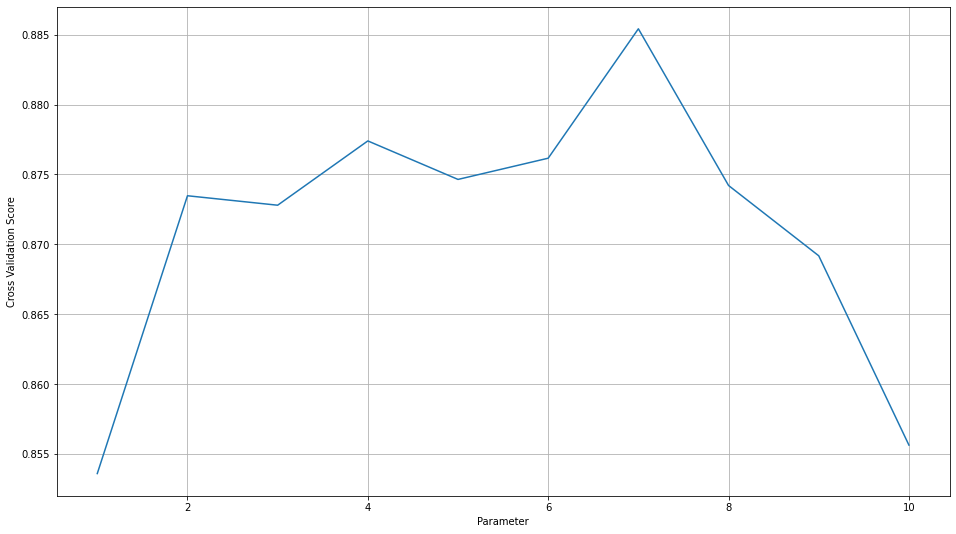

In [63]:
ftwo_scorer = make_scorer(matthews_corrcoef)
model = KNeighborsClassifier()
start_time = time.time()
kf = StratifiedKFold(n_splits=5)
knnparams = {"n_neighbors": [1,2,3,4,5,6,7,8,9,10]}
clf = GridSearchCV(model, knnparams, scoring=ftwo_scorer, cv = kf, n_jobs=-1).fit(X_train,y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_n_neighbors'].data
# collect test scores
results['score'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (16, 9)
plt.plot(results['parameter'], results['score'])
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print('Best Parameter: ', clf.best_params_)
print('Mean Test Score: ', clf.best_score_)
print('Sd Test Score: ', clf.cv_results_['std_test_score'][clf.best_index_])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


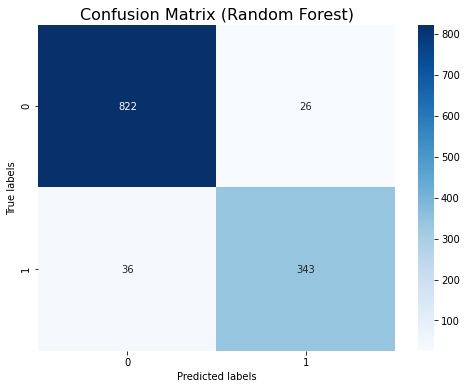

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       848
           1       0.93      0.91      0.92       379

    accuracy                           0.95      1227
   macro avg       0.94      0.94      0.94      1227
weighted avg       0.95      0.95      0.95      1227

MCC Score=0.881


In [64]:
preds = clf.predict(X_test)

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (Random Forest)', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))

### SMOTE

In [65]:
ftwo_scorer = make_scorer(matthews_corrcoef)
imba_pipeline = make_pipeline(SMOTE(random_state=0), KNeighborsClassifier())
start_time = time.time()
kf = StratifiedKFold(n_splits=5)
params = {"n_neighbors": [1,2,3,4,5,6,7,8,9,10]}
new_params = {'kneighborsclassifier__' + key: params[key] for key in params}
clf = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring=ftwo_scorer,n_jobs=-1, return_train_score=True).fit(X_train, y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Done training in 498.62379264831543 seconds.


KeyError: ignored

Best Parameter:  {'kneighborsclassifier__n_neighbors': 6}
Mean Test Score:  0.8692440106494159
Sd Test Score:  0.024516095331579762


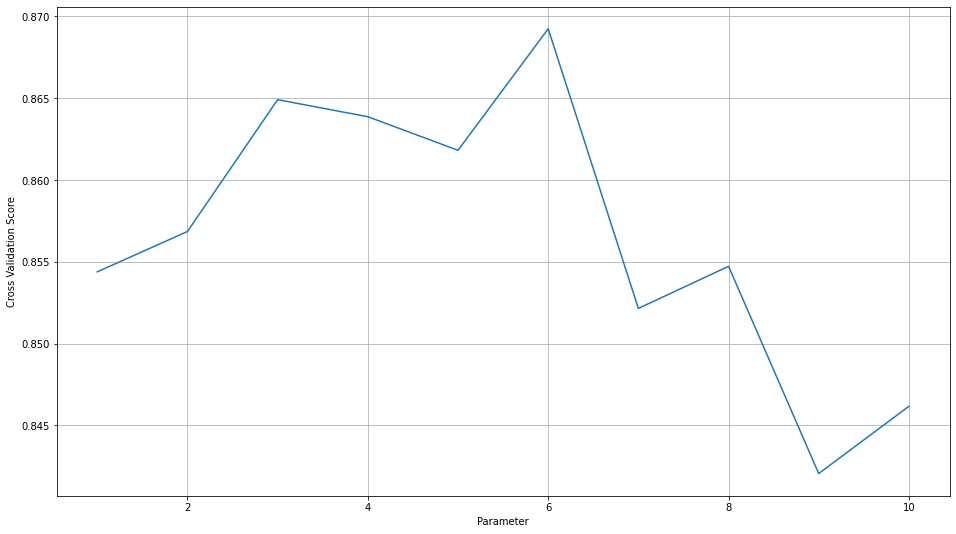

In [66]:
results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_kneighborsclassifier__n_neighbors'].data
# collect test scores
results['score'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (16, 9)
plt.plot(results['parameter'], results['score'])
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print('Best Parameter: ', clf.best_params_)
print('Mean Test Score: ', clf.best_score_)
print('Sd Test Score: ', clf.cv_results_['std_test_score'][clf.best_index_])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


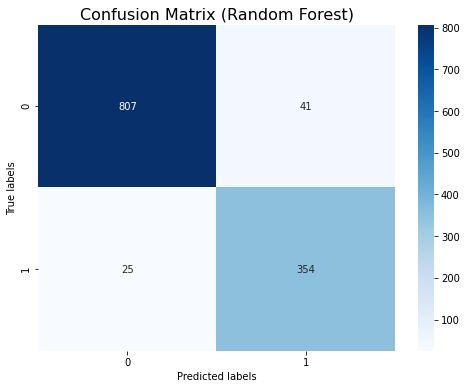

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       848
           1       0.90      0.93      0.91       379

    accuracy                           0.95      1227
   macro avg       0.93      0.94      0.94      1227
weighted avg       0.95      0.95      0.95      1227

MCC Score=0.876


In [67]:
preds = clf.predict(X_test)

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (Random Forest)', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))

## Support Vector Machine

### Baseline Model

Done training in 101.16019487380981 seconds.
{'C': 1.3}
0.8901145268749312
0.018320495116698098


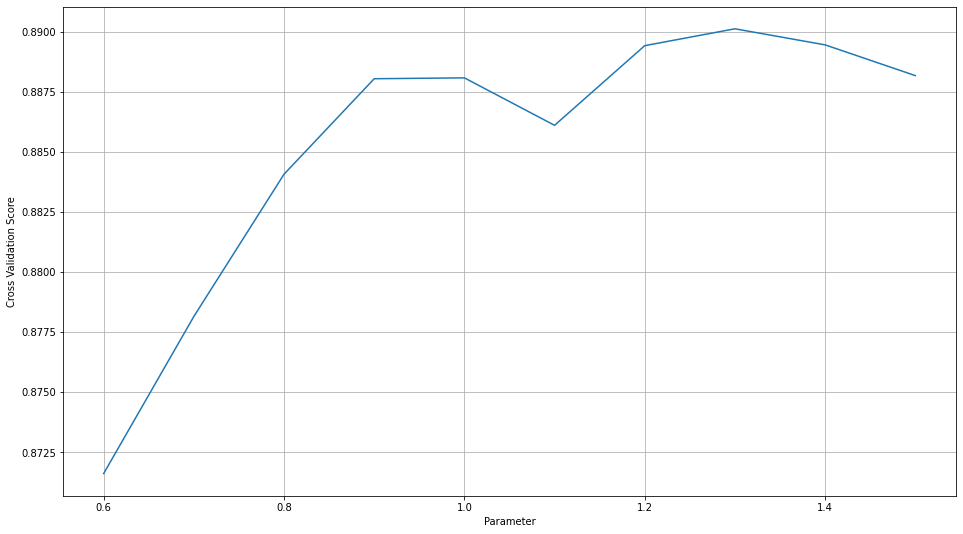

In [68]:
ftwo_scorer = make_scorer(matthews_corrcoef)
model = SVC(random_state=0)
start_time = time.time()
kf = StratifiedKFold(n_splits=5)
svcparams = {'C': [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]} 
clf = GridSearchCV(model, svcparams, scoring=ftwo_scorer, cv = kf, n_jobs=-1).fit(X_train,y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_C'].data
# collect test scores
results['score'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (16, 9)
plt.plot(results['parameter'], results['score'])
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print(clf.best_params_)
print(clf.best_score_)
print(clf.cv_results_['std_test_score'][clf.best_index_])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


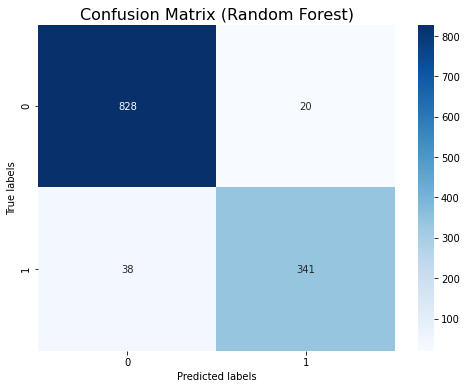

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       848
           1       0.94      0.90      0.92       379

    accuracy                           0.95      1227
   macro avg       0.95      0.94      0.94      1227
weighted avg       0.95      0.95      0.95      1227

MCC Score=0.888


In [69]:
preds = clf.predict(X_test)
#preds_proba = clf.predict_proba(X_test)
#preds_proba = preds_proba[:, 1]

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (Random Forest)', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))

### SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Done training in 269.5296275615692 seconds.
{'svc__C': 1.1}
0.8763125010484061
0.018408349306821285


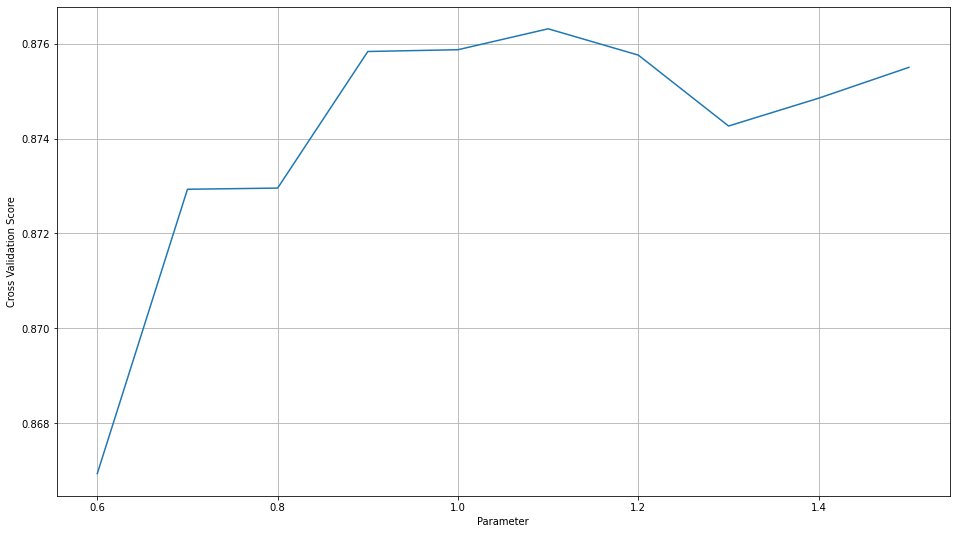

In [72]:
ftwo_scorer = make_scorer(matthews_corrcoef)
imba_pipeline = make_pipeline(SMOTE(random_state=0), SVC(random_state = 0))
start_time = time.time()
kf = StratifiedKFold(n_splits=5)
params = {"C": [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]}
new_params = {'svc__' + key: params[key] for key in params}
clf = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring=ftwo_scorer,n_jobs=-1, return_train_score=True).fit(X_train, y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_svc__C'].data
# collect test scores
results['score'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (16, 9)
plt.plot(results['parameter'], results['score'])
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print(clf.best_params_)
print(clf.best_score_)
print(clf.cv_results_['std_test_score'][clf.best_index_])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


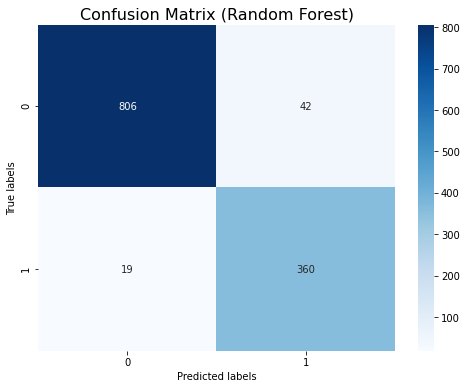

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       848
           1       0.90      0.95      0.92       379

    accuracy                           0.95      1227
   macro avg       0.94      0.95      0.94      1227
weighted avg       0.95      0.95      0.95      1227

MCC Score=0.886


In [74]:
preds = clf.predict(X_test)

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (Random Forest)', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))

### Cost Sensitive

Done training in 106.40487384796143 seconds.
{'C': 1.4}
0.8777857215151231
0.020012292224802244


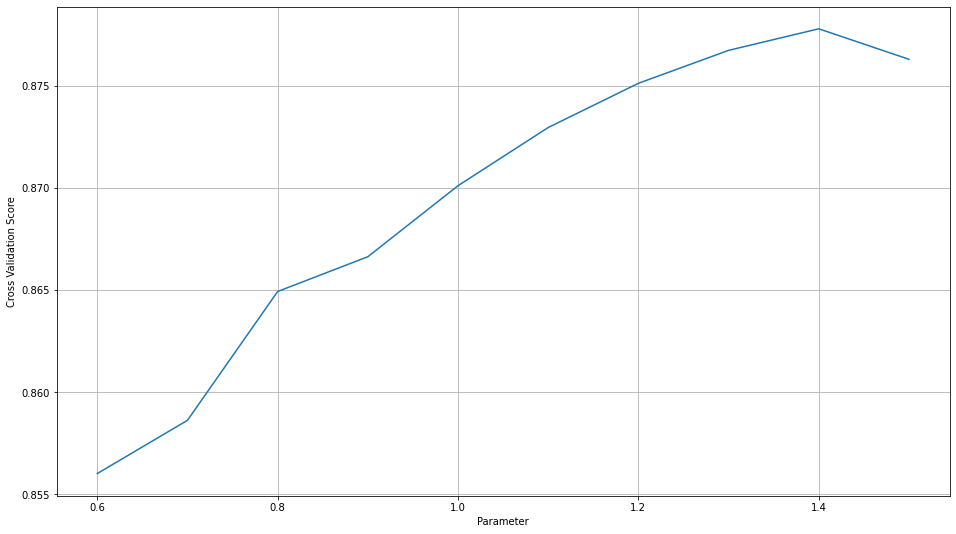

In [70]:
ftwo_scorer = make_scorer(matthews_corrcoef)
model = SVC(random_state=0, class_weight = 'balanced')
start_time = time.time()
kf = StratifiedKFold(n_splits=5)
svcparams = {'C': [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]} 
clf = GridSearchCV(model, svcparams, scoring=ftwo_scorer, cv = kf, n_jobs=-1).fit(X_train,y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_C'].data
# collect test scores
results['score'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (16, 9)
plt.plot(results['parameter'], results['score'])
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print(clf.best_params_)
print(clf.best_score_)
print(clf.cv_results_['std_test_score'][clf.best_index_])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


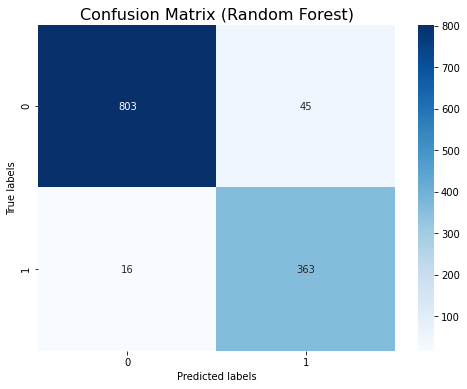

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       848
           1       0.89      0.96      0.92       379

    accuracy                           0.95      1227
   macro avg       0.94      0.95      0.94      1227
weighted avg       0.95      0.95      0.95      1227

MCC Score=0.887


In [71]:
preds = clf.predict(X_test)

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (Random Forest)', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))

## XGBoost

### Baseline Model

In [ ]:
ftwo_scorer = make_scorer(matthews_corrcoef)
model = xgb.XGBClassifier(random_state=0)
start_time = time.time()
kf = StratifiedKFold(n_splits=5)
svcparams = {'C': [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]} 
clf = GridSearchCV(model, svcparams, scoring=ftwo_scorer, cv = kf, n_jobs=-1).fit(X_train,y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_C'].data
# collect test scores
results['score'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (16, 9)
plt.plot(results['parameter'], results['score'])
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print(clf.best_params_)
print(clf.best_score_)
print(clf.cv_results_['std_test_score'][clf.best_index_])

## Neural Network

In [87]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K

Initialising the ANN

In [88]:
classifier = Sequential()

In [89]:
def mcc(y_true, y_pred):
   y_pred_pos = K.round(K.clip(y_pred, 0, 1))
   y_pred_neg = 1 - y_pred_pos

   y_pos = K.round(K.clip(y_true, 0, 1))
   y_neg = 1 - y_pos

   tp = K.sum(y_pos * y_pred_pos)
   tn = K.sum(y_neg * y_pred_neg)

   fp = K.sum(y_neg * y_pred_pos)
   fn = K.sum(y_pos * y_pred_neg)

   numerator = (tp * tn - fp * fn)
   denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

   return numerator / (denominator + K.epsilon())

After the feature engineering this is the next largest amount of work.

I started with a couple of layers (64/31/1) and appropriate model parameters.

The problem is a binary classification which means we use binary_crossentropy as the loss and sigmoid activation on the last layer.
Optimizer is rmsprop (TODO: check other optimizers)

I then iterated over hyperparams to find the best values, tuning each section before moving to the next:

*   Layers
*   Number of epochs
*   Batch size
*   Regularization

Then back through the loop to make sure the later settings hadn't changed the initial tunings.

In [90]:
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu', input_dim = 445))

# Adding the second hidden layer
classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [mcc])

In [91]:
start_time = time.time()
model = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 500, epochs = 500, verbose=0)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

Epoch 1/500
8/8 [==============================] - 3s 68ms/step - loss: 0.6807 - mcc: 0.0737 - val_loss: 0.6338 - val_mcc: 0.2724
Epoch 2/500
8/8 [==============================] - 0s 9ms/step - loss: 0.6089 - mcc: 0.3926 - val_loss: 0.5234 - val_mcc: 0.5425
Epoch 3/500
8/8 [==============================] - 0s 10ms/step - loss: 0.4991 - mcc: 0.6002 - val_loss: 0.4375 - val_mcc: 0.5708
Epoch 4/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4122 - mcc: 0.6213 - val_loss: 0.3746 - val_mcc: 0.6139
Epoch 5/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3437 - mcc: 0.6699 - val_loss: 0.3251 - val_mcc: 0.6322
Epoch 6/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3042 - mcc: 0.6827 - val_loss: 0.2881 - val_mcc: 0.6673
Epoch 7/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2685 - mcc: 0.7321 - val_loss: 0.2504 - val_mcc: 0.7344
Epoch 8/500
8/8 [==============================] - 0s 11ms/step - loss: 0.2196 - mcc: 0.7678 - 

Using matthews correlation coefficient, compares how many we predicted correctly compared to how many predicted incorrectly.
A more useful measure than binary_crossentropy due to the weighted dataset we have.

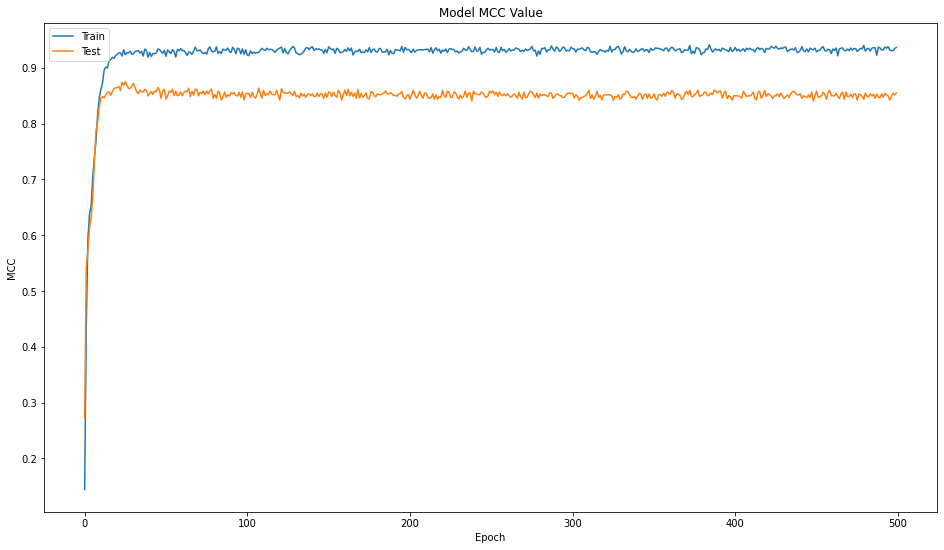

In [93]:
import matplotlib.pyplot as plt

plt.plot(model.history['mcc'])
plt.plot(model.history['val_mcc'])

plt.title('Model MCC Value')
plt.ylabel('MCC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [94]:
# evaluate the keras model
_, mcc = classifier.evaluate(X_test, y_test, verbose=0)
print('MCC: %.2f' % (mcc*100))

MCC: 85.56


In [ ]:
# make class predictions with the model
predictions = classifier.predict_classes(X_train)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

## Model Selection